<a href="https://colab.research.google.com/github/rahiakela/hands-on-explainable-ai-xai-with-python/blob/main/1-explaining-artificial-intelligence-with-python/1_exploring_simple_knn_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exploring a simple KNN algorithm

We will begin by exploring a simple KNN algorithm that can predict a disease with a few symptoms. We will limit our study to detecting the flu, a cold, or pneumonia. The number of symptoms will be limited to a cough, fever, headache, and colored sputum.

From the doctor's perspective, the symptoms are generally viewed as follows:

- A mild headache and a fever could be a cold
- A cough and fever could be a flu
- A fever and a cough with colored sputum could be pneumonia

Notice the verb is "could" and not "must." **A medical diagnosis remains a probability in the very early stages of a disease. A probability becomes certain only after a few minutes to a few days, and sometimes even weeks.**

## k-nearest neighbors

The KNN algorithm is best explained with a real-life example. Imagine you are in
a supermarket. The supermarket is the dataset. You are at point $p_n$ in an aisle of the supermarket. You are looking for bottled water. You see many brands of bottled water spread over a few yards (or meters). You are also tempted by some cans of soda you see right next to you; however, you want to avoid sugar.

In terms of what's best for your diet, we will use a scale from 1 (very good for your health) to 10 (very bad for your health). $p_n$ is at point (0, 0) in a Euclidian space in which the first term is $x$ and the second $y$.

The many brands of bottled water are between (0, 1) and (2, 2) in terms of their
features in terms of health standards. The many brands of soda, which are generally bad in terms of health standards, have features between (3, 3) and (10, 10).

To find the nearest neighbors in terms of health features, for example, the KNN
algorithm will calculate the Euclidean distance between pn and all the other points in our dataset. The calculation will run from $p_1$ to $p_{n-1}$ using the Euclidean distance formula. The $k$ in KNN represents the number of "nearest neighbors" the algorithm will consider for classification purposes. 

The Euclidean distance ($d_1$) between two given points, such as between $p_n(x_1, y_1)$ and $p_1(x_2, y_2)$, for example, is as follows:

$$ d_1(p_n, p_1) = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2} $$

Intuitively, we know that the data points located between (0, 1) and (2, 2) are closer to our point (0, 0) than the data points located between (3, 3) and (10, 10). The nearest neighbors of our point (0, 0), are the bottled water data points.

Note that these are representations of the closest features to us, not the physical points in the supermarket. The fact that the soda is close to us in the real world of the supermarket does not bring it any closer to our need in terms of our health requirements.

Considering the number of distances to calculate, a function such as the one
provided by sklearn.neighbors proves necessary. We will now go back to our
medical diagnosis program and build a KNN in Python.

## Setup

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

In [2]:
!wget https://raw.githubusercontent.com/rahiakela/hands-on-explainable-ai-xai-with-python/main/1-explaining-artificial-intelligence-with-python/D1.csv

--2021-03-07 13:41:42--  https://raw.githubusercontent.com/rahiakela/hands-on-explainable-ai-xai-with-python/main/1-explaining-artificial-intelligence-with-python/D1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3229 (3.2K) [text/plain]
Saving to: ‘D1.csv’

D1.csv              100%[===================>]   3.15K  --.-KB/s    in 0s      

2021-03-07 13:41:42 (48.3 MB/s) - ‘D1.csv’ saved [3229/3229]



## Loading dataset

We now read the file and display a partial view of its content:

In [9]:
df = pd.read_csv("D1.csv")
df2 = pd.read_csv("D1.csv")
print(df)

     colored_sputum  cough  fever  headache class
0               1.0    3.5    9.4       3.0   flu
1               1.0    3.4    8.4       4.0   flu
2               1.0    3.3    7.3       3.0   flu
3               1.0    3.4    9.5       4.0   flu
4               1.0    2.0    8.0       3.5   flu
..              ...    ...    ...       ...   ...
145             0.0    1.0    4.2       2.3  cold
146             0.5    2.5    2.0       1.7  cold
147             0.0    1.0    3.2       2.0  cold
148             0.4    3.4    2.4       2.3  cold
149             0.0    1.0    3.1       1.8  cold

[150 rows x 5 columns]


The four features are the four symptoms we need: colored sputum, cough, fever, and headache.

In [10]:
df.head()

,colored_sputum,cough,fever,headache,class
0,1.0,3.5,9.4,3.0,flu
1,1.0,3.4,8.4,4.0,flu
2,1.0,3.3,7.3,3.0,flu
3,1.0,3.4,9.5,4.0,flu
4,1.0,2.0,8.0,3.5,flu


The class column contains the three diseases we must predict: cold, flu,
and pneumonia.

In [11]:
df["class"].value_counts()

cold         50
pneumonia    50
flu          50
Name: class, dtype: int64

## Data exploration

The values of each of the features in the dataset range from 0 to 9.9. They represent the risk level of a symptom. Decimal values are used when necessary.

- **colored_sputum**: If the value is 0, the patient does not cough sputum. If the
value is 3, the patient is coughing some sputum. If the value is 9, then the
condition is serious. If it is 9.9 then the colored sputum is at the maximum
level.

- **cough**: If the value of cough is 1, and colored_sputum also has a low value, such as 1, then the patient is not acutely ill. If the value is high, such as 7, and colored_sputum is high as well, the patient might have pneumonia. The value of fever will provide more information.

- **fever**: If fever is low, such as level 2, and the other values are also low, there is not much to worry about for the moment. However, if fever goes up with one of the other features going up, then the program will use the labels to
train and provide a prediction and an explanation if headache also has a high
level.

- **headache**: For the West Nile virus, a high-value headache, such as 7, along
with a high level of coughing, is a trigger to send the patient to the hospital
immediately to test for the virus and avoid encephalitis, for example.

At the same time, the novel coronavirus, COVID-19, was beginning to appear,
making a diagnosis even more difficult. A severe headache with high fever and
coughing led away from COVID-19 as a hypothesis. Many patients have serious
symptoms that are not from COVID-19.

## Training KNN classifier

In [12]:
# KNN classification labels
X = df.loc[:, "colored_sputum": "headache"]
Y = df.loc[:, "class"]

# train the model
knn = KNeighborsClassifier()
knn.fit(X, Y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

The output shows the default values of the KNN classifier that we will have to
explain at some point.

If an expert requested an explanation, an interface could provide the following
details:

- **algorithm='auto'**: This will choose the best algorithm based on the values.
- **leaf_size=30**: The leaf size sent to BallTree or to KDTree.
- **metric='minkowski'**: The distance metric is the Minkowski metric, which
uses a specific tensor for the calculation.
- **n_jobs=None**: The number of parallel jobs that can be run.
- **n_neighbors=5**: The number of neighbors to take into account.
- **weights='uniform'**: All weights have a uniform value.


The goal of the experiment is to explain how the program came up with the West Nile virus in such a way that a general practitioner could trust the prediction and send the patient to hospital for treatment.

We now can now move on and visualize the trained model's output using
matplotlib:

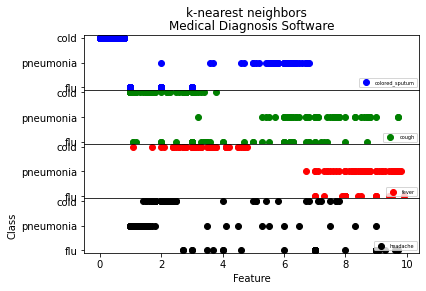

In [14]:
# Plotting the relation of each feature with each class
df = df2
figure, (sub1, sub2, sub3, sub4) = plt.subplots(4, sharex=True, sharey=True)
plt.suptitle('k-nearest neighbors')
plt.xlabel('Feature')
plt.ylabel('Class')

X = df.loc[:, "colored_sputum"]
Y = df.loc[:, "class"]
sub1.scatter(X, Y, color="blue", label="colored_sputum")
sub1.legend(loc=4, prop={"size": 5})

sub1.set_title("Medical Diagnosis Software")

X = df.loc[:, "cough"]
Y = df.loc[:, "class"]
sub2.scatter(X, Y, color="green", label="cough")
sub2.legend(loc=4, prop={"size": 5})

X = df.loc[:, "fever"]
Y = df.loc[:, "class"]
sub3.scatter(X, Y, color="red", label="fever")
sub3.legend(loc=4, prop={"size": 5})

X = df.loc[:, "headache"]
Y = df.loc[:, "class"]
sub4.scatter(X, Y, color="black", label="headache")
sub4.legend(loc=4, prop={"size": 5})

figure.subplots_adjust(hspace=0)
plt.show()

The doctor can use an intuitive form to quickly enter the severity of each symptom on a scale of 0 to 9.9:

In [27]:
# @title Evaluation form
colored_sputum =  1 # @param {type:"integer"}
cough=3             # @param {type:"integer"}
fever=7             # @param {type:"integer"}
headache=5          # @param {type:"integer"}

The program uses these values to create the input of the prediction the KNN now
runs:

In [28]:
# colored_sputum, cough, fever, headache
cs = colored_sputum; c = cough; f = fever; h = headache;
X_DL = [[cs, c, f, h]]

prediction = knn.predict(X_DL)
print("The prediction is:", str(prediction).strip("[]"))

The prediction is: 'flu'


The critical issue we have as AI specialists resides in the fact that, at first, the doctor does not trust AI or any other system to make life or death decisions. So, our concern was to explain AI to a doctor, not a developer. A user needs to be able to trust the XAI system enough to make a decision.

Doctors are ready to use AI. We need to explain the predictions, not just
make them.

We are now at the heart of XAI. When the KNN runs with perfect accuracy but does
not provide the diagnosis that will save a patient's life, the prediction is either a false positive if it produces the wrong prediction, or a false negative if it missed it! The whole point of people-centered AI is to
detect weaknesses in our ML predictions and find innovative ways of improving the prediction.